## OCR
> OCR implementation using PaddleOCR running on Triton using ONNX

### PaddleOCR inference steps



#### Args


| Name | Default | Description |
| --- | --- | --- |
| rec_batch_num | 6 | Batch size for inference |
| rec_algorithm | SVTR_LCNet | Recognition algorithm |
| postprocess_params.name | CTCLabelDecode | Name of the postprocess pipeline to use  |
| postprocess_params.character_dict_path | ?? | Path to the dictionary file |
| postprocess_params.use_space_char | True | Whether to use the space character |

#### Steps

1. Resize and normalize image
2. Create predictor with mode = 'rec'
3. Postprocess the results from the predictor



In [1]:
#| default_exp ocr
#| export
import dataclasses
import math
import os
import pathlib
import re

from typing import Any, List, Tuple

import cv2
import dataclasses_json
import mlflow
import numpy as np
import numpy.typing as nptypes
import onnxruntime as ort
from PIL import Image

from csgo_clips_autotrim.experiment_utils.config import InferenceConfig

In [2]:
#| export
mlflow.set_tracking_uri('https://mlflow.tenzing.shkhr.ovh')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'https://minio-api.tenzing.shkhr.ovh'

def get_ocr_dictionary(run_id: str) -> os.PathLike:
    """Get the recognition model dictionary from mlflow's artifact store.

    Args:
        run_id (str)

    Returns:
        os.PathLike: Local path to the dictionary file.
    """
    return mlflow.artifacts.download_artifacts(artifact_uri=f'runs:/{run_id}/dict.txt')

In [3]:
#| export
@dataclasses_json.dataclass_json
@dataclasses.dataclass
class OCRResult:
    text: str
    confidence: float

In [5]:
from csgo_clips_autotrim.experiment_utils.constants import BASE_DIR
from csgo_clips_autotrim.segmentation.elimination import EliminationSegmentationResult

OUT_DIR = BASE_DIR / 'nbs' / 'out'

In [6]:
SAMPLE_FRAME_IMG = OUT_DIR / 'd2_1v4_ace_00028.png'
SAMPLE_EVENTS_JSON = OUT_DIR / 'd2_1v4_ace_00028.json'

assert SAMPLE_FRAME_IMG.exists()
assert SAMPLE_EVENTS_JSON.exists()

In [7]:
with open(SAMPLE_EVENTS_JSON, 'r') as f:
    segmentation_result: EliminationSegmentationResult = EliminationSegmentationResult.schema().loads(f.read())

In [8]:
file_path = OUT_DIR / f'{segmentation_result.frame_info.name}.png'
img = Image.open(file_path)
np.asarray(img).shape

(360, 640, 3)

In [9]:
from csgo_clips_autotrim.segmentation.elimination import get_eliminator_bbox, get_eliminated_bbox


event = segmentation_result.elimination_events[1]
eliminator_img = img.crop(get_eliminator_bbox(event).dims).resize((200, 20))
eliminator_img

In [10]:
eliminated_img = img.crop(get_eliminated_bbox(event).dims).resize((200, 20))

In [11]:
eliminated_img

In [12]:
#| export
class BaseRecLabelDecode(object):
    """ Convert between text-label and text-index """

    def __init__(self, character_dict_path=None, use_space_char=False):
        self.beg_str = "sos"
        self.end_str = "eos"
        self.reverse = False
        self.character_str = []

        if character_dict_path is None:
            self.character_str = "0123456789abcdefghijklmnopqrstuvwxyz"
            dict_character = list(self.character_str)
        else:
            with open(character_dict_path, "rb") as fin:
                lines = fin.readlines()
                for line in lines:
                    line = line.decode('utf-8').strip("\n").strip("\r\n")
                    self.character_str.append(line)
            if use_space_char:
                self.character_str.append(" ")
            dict_character = list(self.character_str)
            if 'arabic' in character_dict_path:
                self.reverse = True

        dict_character = self.add_special_char(dict_character)
        self.dict = {}
        for i, char in enumerate(dict_character):
            self.dict[char] = i
        self.character = dict_character

    def pred_reverse(self, pred):
        pred_re = []
        c_current = ''
        for c in pred:
            if not bool(re.search('[a-zA-Z0-9 :*./%+-]', c)):
                if c_current != '':
                    pred_re.append(c_current)
                pred_re.append(c)
                c_current = ''
            else:
                c_current += c
        if c_current != '':
            pred_re.append(c_current)

        return ''.join(pred_re[::-1])

    def add_special_char(self, dict_character):
        return dict_character

    def decode(self, text_index, text_prob=None, is_remove_duplicate=False):
        """ convert text-index into text-label. """
        result_list = []
        ignored_tokens = self.get_ignored_tokens()
        batch_size = len(text_index)
        for batch_idx in range(batch_size):
            selection = np.ones(len(text_index[batch_idx]), dtype=bool)
            if is_remove_duplicate:
                selection[1:] = text_index[batch_idx][1:] != text_index[
                    batch_idx][:-1]
            for ignored_token in ignored_tokens:
                selection &= text_index[batch_idx] != ignored_token

            char_list = [
                self.character[text_id]
                for text_id in text_index[batch_idx][selection]
            ]
            if text_prob is not None:
                conf_list = text_prob[batch_idx][selection]
            else:
                conf_list = [1] * len(selection)
            if len(conf_list) == 0:
                conf_list = [0]

            text = ''.join(char_list)

            if self.reverse:  # for arabic rec
                text = self.pred_reverse(text)

            result_list.append((text, np.mean(conf_list).tolist()))
        return result_list

    def get_ignored_tokens(self):
        return [0]  # for ctc blank



class CTCLabelDecode(BaseRecLabelDecode):
    """ Convert between text-label and text-index """

    def __init__(self, character_dict_path=None, use_space_char=False,
                 **kwargs):
        super(CTCLabelDecode, self).__init__(character_dict_path,
                                             use_space_char)

    def __call__(self, preds, label=None, *args, **kwargs):
        if isinstance(preds, tuple) or isinstance(preds, list):
            preds = preds[-1]

        # if isinstance(preds, paddle.Tensor):
        #     preds = preds.numpy()

        preds_idx = preds.argmax(axis=2)
        preds_prob = preds.max(axis=2)
        text = self.decode(preds_idx, preds_prob, is_remove_duplicate=True)
        if label is None:
            return text
        label = self.decode(label)
        return text, label

    def add_special_char(self, dict_character):
        dict_character = ['blank'] + dict_character
        return dict_character


In [13]:
#| export
import abc

class OCR(abc.ABC):
    def recognize(self, img: nptypes.ArrayLike) -> List[OCRResult]:
        ...

class LocalOCR(OCR):
    def __init__(self, model_dir_path: os.PathLike):
        self._init_args()

        model_dir = pathlib.Path(model_dir_path).parent
        self._model_path = model_dir / 'model.onnx'
        self._dict_path = model_dir / 'dict.txt'

        self._session, self._input_tensor = self._create_predictor()
        self._postprocess_op = CTCLabelDecode(self._dict_path.as_posix(), True)
    
    def _init_args(self):
        self._rec_algorithm = 'SVTR_LCNet'
        self._output_name = 'softmax_0.tmp_0'
        self._rec_image_shape = (3, 48, 320)

        imgC, imgH, imgW = self._rec_image_shape
        self._rec_img_wh_ratio = imgW / imgH

    def _create_predictor(self) -> Tuple[ort.InferenceSession, Any]:
        session = ort.InferenceSession(self._model_path)

        return session, session.get_inputs()[0]
    
    def _get_resized_normalized_image(self, img: nptypes.ArrayLike) -> nptypes.ArrayLike:
        h, w, c = img.shape
        max_wh_ratio = max(self._rec_img_wh_ratio, w * 1.0 / h)

        imgC, imgH, imgW = self._rec_image_shape

        assert imgC == img.shape[2]
        imgW = int((imgH * max_wh_ratio))

        ratio = w / float(h)
        if math.ceil(imgH * ratio) > imgW:
            resized_w = imgW
        else:
            resized_w = int(math.ceil(imgH * ratio))

        resized_image = cv2.resize(img, (resized_w, imgH))
        resized_image = resized_image.astype('float32')
        resized_image = resized_image.transpose((2, 0, 1)) / 255
        resized_image -= 0.5
        resized_image /= 0.5
        padding_im = np.zeros((imgC, imgH, imgW), dtype=np.float32)
        padding_im[:, :, 0:resized_w] = resized_image

        return padding_im
    
    def recognize(self, img: nptypes.ArrayLike) -> List[OCRResult]:
        resized_img = self._get_resized_normalized_image(img)
        input_dict = {}

        resized_img_batch = resized_img[np.newaxis, :]
        input_dict[self._input_tensor.name] = resized_img_batch

        output = self._session.run(None, input_dict)
        preds = output[0]
        print(preds.shape)
        results = self._postprocess_op(preds)

        return [OCRResult(text, confidence) for text, confidence in results]

(1, 60, 97)
[OCRResult(text='prezzi cs.money', confidence=0.9278367161750793)]


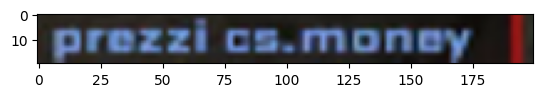

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

ocr = LocalOCR('/home/shikhar/dev/csgo-clips-autotrim/nbs/out/models/paddleocr/rec_model/model.onnx')
preds = ocr.recognize(np.asarray(eliminated_img))
print(preds)
plt.imshow(eliminated_img)

In [15]:
#| export
import tritonclient.http as httpclient

class TritonOCR(LocalOCR):
    def __init__(self, inference_config: InferenceConfig):
        self._init_args()

        self._inference_client = httpclient.InferenceServerClient(url=inference_config.triton_url)
        self._inference_config = inference_config
        self._input_name = 'x'
        self._output_name = 'softmax_2.tmp_0'

        # Download the dict file from the MLFlow run.
        self._dict_path = get_ocr_dictionary(inference_config.mlflow_artifact_run_id)
        self._postprocess_op = CTCLabelDecode(character_dict_path=self._dict_path, use_space_char=True)
    
    def recognize(self, img: nptypes.ArrayLike) -> List[OCRResult]:
        resized_img = self._get_resized_normalized_image(img)
        resized_img_batch = resized_img[np.newaxis, :]

        inputs = httpclient.InferInput(self._input_name, resized_img_batch.shape, datatype='FP32')
        inputs.set_data_from_numpy(resized_img_batch, binary_data=True)

        output = httpclient.InferRequestedOutput(self._output_name, binary_data=True)

        raw_output = self._inference_client.infer(model_name=self._inference_config.triton_model_name, inputs=[inputs], outputs=[output])
        output = raw_output.as_numpy(self._output_name)
        results = self._postprocess_op(output)

        return [OCRResult(text, confidence) for text, confidence in results]

In [16]:
inference_config = InferenceConfig(mlflow_artifact_run_id='9a143aad0ca04da583484b3471248aed',
                                   triton_model_name='paddleocr-en_PP-OCRv3-rec',
                                   triton_url='localhost:8000',
                                   score_threshold=0.5)

triton_ocr = TritonOCR(inference_config)
triton_ocr.recognize(np.asarray(eliminated_img))

[INFO] 2023-08-06 18:10:04,692 botocore.credentials: Found credentials in shared credentials file: ~/.aws/credentials


[OCRResult(text='prezzi cs.money', confidence=0.9278367161750793)]

In [17]:
triton_ocr.recognize(np.asarray(eliminator_img))

[OCRResult(text='Oblue+Sanvi', confidence=0.9210050702095032)]